In [10]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import model_selection, feature_selection, ensemble, linear_model, metrics
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn_relief as relief
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential
import pickle, os, joblib

In [2]:
df = pd.read_excel("trainDataset.xls")
df.drop('ID', axis=1, inplace=True)
df= df.rename(columns={"RelapseFreeSurvival (outcome)":"Y_reg", "pCR (outcome)":"Y_clf"}) 
df.head()

,Y_clf,Y_reg,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0.0,0.0,1.0,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1.0,0.0,0.0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0.0,0.0,1.0,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0.0,0.0,1.0,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0.0,0.0,0.0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


---
# Missing value & outliners dealing

In [17]:
from scipy import stats
categoricalTitles = ['Y_clf','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage']
for c in df.columns:
    if c in categoricalTitles:
        continue
    q1Pos = 0.1
    q3Pos = 0.9
    q1=df[c].quantile(q1Pos)
    q3=df[c].quantile(q3Pos)
    IQR=q3-q1
    upper_limit = q3+1.5*IQR
    lower_limit = q1-1.5*IQR
    outliers = df[c][((df[c]<(q1-1.5*IQR)) | (df[c]>(q3+1.5*IQR)))]
    
    df[c] = df[c].apply(lambda x : np.where(x > upper_limit, np.nan, np.where(x < lower_limit, np.nan, x)))

In [18]:
df = df.replace(999,np.nan)
df.columns[df.isna().any()].tolist()

['original_shape_MeshVolume',
 'original_shape_VoxelVolume',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Median',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_glcm_Autocorrelation',
 'original_glcm_ClusterShade',
 'original_glcm_Imc1',
 'original_glcm_SumAverage',
 'original_gldm_HighGrayLevelEmphasis',
 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
 'original_glrlm_LongRunLowGrayLevelEmphasis',
 'original_glrlm_RunLengthNonUniformity',
 'original_glszm_GrayLevelNonUniformity',
 'original_glszm_LargeAreaEmphasis',
 'original_glszm_LargeAreaHighGrayLevelEmphasis',
 'original_glszm_LargeAreaLowGrayLevelEmphasis',
 'original_glszm_SizeZoneNonUniformity',
 'original_glszm_SizeZoneNonUniformityNormalized',
 'original_glszm_ZoneVariance',
 'original_ngtdm_Busyness']

0


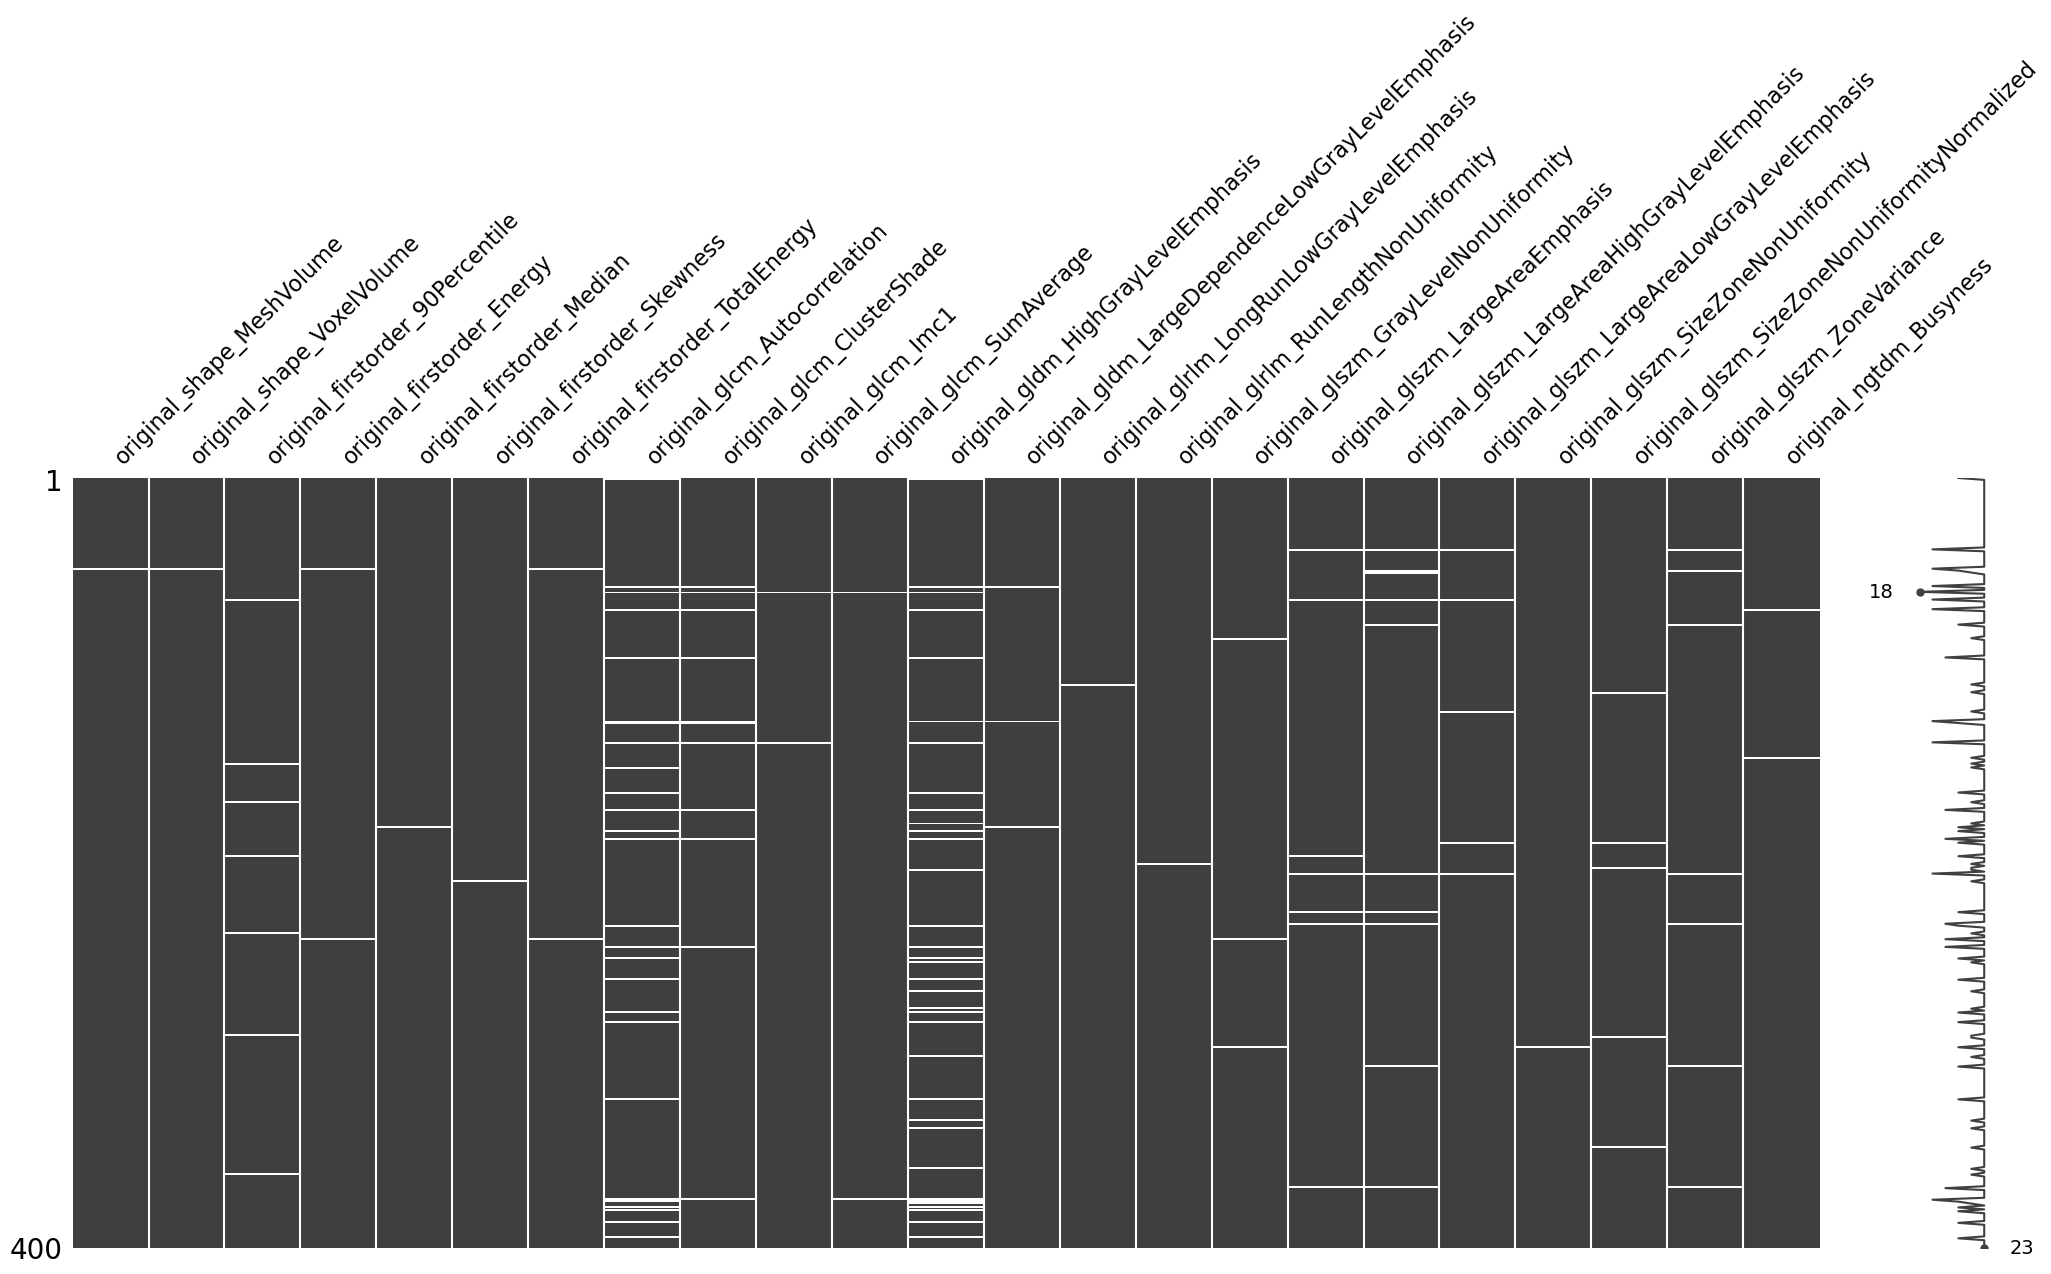

In [19]:
import missingno as msno
null_cols = df.columns[df.isnull().any()]
msno.matrix(df[null_cols])

#knn imputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)

result = imputer.fit_transform(df)
nonNulldataFrame = pd.DataFrame(result, columns= df.columns.tolist())
nonNulldataFrame = nonNulldataFrame[null_cols].apply(lambda x: round(x))
df = df.drop(null_cols, axis=1)
df = pd.concat([df, nonNulldataFrame], axis=1)
#checking for missing
#nonNulldataFrame.to_csv("test.csv")
print(nonNulldataFrame.isnull().sum().sum())

In [20]:
df.head()

,Y_reg,Age,ER,TumourStage,original_shape_Elongation,original_shape_Flatness,original_shape_Maximum2DDiameterColumn,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_firstorder_10Percentile,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_RunLengthNonUniformity,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_ZoneVariance,original_ngtdm_Busyness
0,144.0,41.0,0,2,0.813912,0.724080,37.696154,0.771675,0.258736,-0.163500,...,11.0,677.0,28.0,4067579.0,15655225.0,1170667.0,6.0,0.0,3880772.0,473.0
1,142.0,39.0,1,2,0.666118,0.476173,51.971146,0.603481,0.330900,0.665558,...,28.0,160.0,78.0,2403756.0,9614769.0,601003.0,16.0,0.0,2372010.0,59.0
2,135.0,31.0,0,2,0.645083,0.594470,32.984845,0.608183,0.359083,0.638035,...,25.0,114.0,72.0,1561963.0,6247801.0,390504.0,20.0,0.0,1540027.0,34.0
3,12.0,35.0,0,3,0.770842,0.501228,66.910388,0.474509,0.340781,0.759496,...,31.0,213.0,99.0,7007671.0,28030626.0,1751932.0,26.0,0.0,6936741.0,47.0
4,109.0,61.0,1,2,0.861035,0.750267,33.241540,0.756228,0.309200,0.434385,...,28.0,101.0,56.0,1288914.0,5155465.0,322276.0,13.0,0.0,1265399.0,40.0


---
# Standard Scaler

In [21]:
## standard scaler for image features
cols = ['Y_clf','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage','Y_reg']
df_num = df.drop(cols, axis=1)
scalar = StandardScaler()
df_cols = df_num.columns.tolist()
scaled_data = pd.DataFrame(scalar.fit_transform(df_num), columns=df_cols)
scaled_data 
## PCA to do reduction on each type of image features

# #normalisation for non-image, non-categorical features
# df_pca = df.iloc[:,0:]
# df_pca = pd.DataFrame(scalar.fit_transform(df_pca), columns=df_pca.columns.tolist())
df_pca = pd.concat([df[cols], scaled_data], axis=1)
df_pca

,Y_clf,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_RunLengthNonUniformity,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_ZoneVariance,original_ngtdm_Busyness
0,1.0,0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,2,...,-0.871036,1.364186,-0.268784,-0.389816,-0.395511,-0.369371,-0.306499,0.0,-0.357504,2.445067
1,0.0,1,1.0,0.0,0.0,3.0,3.0,1.0,1.0,2,...,0.541567,-0.522483,0.781359,-0.504520,-0.517886,-0.516235,0.638756,0.0,-0.484327,-0.401412
2,1.0,0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2,...,0.292284,-0.690349,0.655342,-0.562554,-0.586097,-0.570504,1.016857,0.0,-0.554262,-0.573301
3,0.0,0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,3,...,0.790850,-0.329072,1.222419,-0.187124,-0.144796,-0.219515,1.584010,0.0,-0.100624,-0.483919
4,0.0,1,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2,...,0.541567,-0.737790,0.319296,-0.581378,-0.608227,-0.588094,0.355179,0.0,-0.577347,-0.532048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,4,...,-0.787942,0.762057,-0.205776,0.520425,0.686513,0.443192,-0.306499,0.0,0.721126,-0.257025
396,0.0,0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2,...,-1.203413,-0.982290,-0.814858,-0.650578,-0.689564,-0.652800,-0.684600,0.0,-0.665793,-0.800194
397,0.0,1,0.0,0.0,0.0,3.0,3.0,1.0,1.0,3,...,0.873944,-0.350968,-0.268784,0.769822,0.974983,0.691255,-0.495550,0.0,1.004202,0.602419
398,0.0,1,0.0,0.0,0.0,2.0,1.0,1.0,1.0,2,...,-1.037225,-0.730491,-0.331793,-0.630033,-0.665416,-0.633591,0.166128,0.0,-0.636564,-0.738314


---
# Feature Selection

In [22]:
""" cols = [
 'original_shape_Sphericity',
 'original_shape_SurfaceVolumeRatio',
 'original_firstorder_Kurtosis',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Minimum',
 'original_glcm_ClusterProminence',
 'original_glcm_Contrast',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceAverage',
 'original_glcm_JointEnergy',
 'original_glcm_Id',
 'original_glcm_Idm',
 'original_glcm_Imc1',
 'original_glcm_Imc2',
 'original_glcm_Idmn',
 'original_glcm_Idn',
 'original_glrlm_ShortRunEmphasis',
 'original_glrlm_LongRunEmphasis',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_RunPercentage',
 'original_glrlm_ShortRunLowGrayLevelEmphasis',
 'original_glrlm_LongRunLowGrayLevelEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'LNStatus',
 'Age'] """

""" cols = ['original_glcm_Contrast',  #marcov blanket
'original_glcm_DifferenceAverage', 
'original_glcm_Id', 
'original_glcm_Idm', 
'original_glcm_Idmn', 
'original_glcm_Idn', 
'original_glcm_JointEntropy', 
'original_firstorder_Range', 
'original_glrlm_LongRunHighGrayLevelEmphasis', 
'original_glrlm_ShortRunLowGrayLevelEmphasis', 
'Proliferation', 'original_shape_VoxelVolume', 
'original_firstorder_Mean', 
'original_firstorder_Variance', 
'original_firstorder_90Percentile', 
'original_glcm_InverseVariance', 
'TumourStage', 
'original_glszm_SizeZoneNonUniformityNormalized', 
'original_firstorder_InterquartileRange', 
'original_firstorder_10Percentile', 
'original_firstorder_Kurtosis', 
'original_shape_MajorAxisLength', 
'original_glcm_DifferenceEntropy',
'original_shape_SurfaceArea', 
'original_glcm_Autocorrelation', 
'original_shape_MeshVolume', 
'original_firstorder_Skewness'] """



#cols = ['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
                    #   'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy', 'original_glcm_Id',
                    #   'original_glcm_Idm', 'LNStatus']

print(len(cols))
X = df_pca[cols].values
#X = df_pca.drop(['Y_reg', 'Y_clf'], axis=1).values
y = df_pca['Y_reg'].values

27


In [ ]:
#### save & load model
## joblib.dump(Lmodel.best_estimator_, "Lreg_not_nested.joblib")
## joblib.load(' ' )

####Ann keras save & load
"""
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')

json_file = open('model.json')
loaded_model = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model)
loaded_model.loaded_weights('model.h5')

loaded_model.compile()
score = loaded_model.evaluate()
"""

"""
model.save('my_model', save_format='h5')

model = load_model('my_model')
model = keras.model.load_model('my_model')
"""

---
## 1.1 Non nested GridsearchCV on the whole dataset (CV=10)

In [23]:
""" 25 features Non nested GridSearchCV only"""
inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

Lmodel = GridSearchCV(estimator=Lreg, param_grid=lreg_parameters, scoring='neg_mean_absolute_error', cv=outer_cv, n_jobs=2)
Lmodel.fit(X, y)
print("Lreg MAE score: {}".format(-Lmodel.best_score_))
print("Lreg best param: {}".format(Lmodel.best_params_))
print("Lreg best estimator: {}\n".format(Lmodel.best_estimator_))

############################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

DTmodel = GridSearchCV(estimator=DTreg, param_grid=dt_parameters, scoring='neg_mean_absolute_error', cv=outer_cv, n_jobs=2)
DTmodel.fit(X, y)
print("DTreg MAE score: {}".format(-DTmodel.best_score_))
print("DTreg best param: {}".format(DTmodel.best_params_))
print("DTreg best estimator: {}\n".format(DTmodel.best_estimator_))

############################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf'],
           "gamma":[0.1,1.0,10.0,'scale','auto']}

## call model
SVMreg = svm.SVR()

SVMmodel = GridSearchCV(estimator=SVMreg, param_grid=svm_parameters, scoring='neg_mean_absolute_error', cv=outer_cv, n_jobs=2)
SVMmodel.fit(X, y)
print("SVMreg MAE score: {}".format(-SVMmodel.best_score_))
print("SVMreg best param: {}".format(SVMmodel.best_params_))
print("SVMreg best estimator: {}\n".format(SVMmodel.best_estimator_))

Lreg MAE score: 21.19503435117317
Lreg best param: {'fit_intercept': True}
Lreg best estimator: LinearRegression()

DTreg MAE score: 21.029548195276934
DTreg best param: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3}
DTreg best estimator: DecisionTreeRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=3)

SVMreg MAE score: 20.637323397565382
SVMreg best param: {'gamma': 'auto', 'kernel': 'rbf'}
SVMreg best estimator: SVR(gamma='auto')



In [ ]:
# ### ANN model
# # k-fold cross validation
# ann_parameters = {"units1":[2,5,8,11,14,17,20],
# "units2":[2,5,8,11,14,17,20],
# "units3":[2,5,8,11,14,17,20],
# "activation1": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation2": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation3": ['relu','tanh', 'sigmoid', 'exponential']}

# parameters = {"units1":[5],
# "units2":[5],
# "units3":[5],
# "activation1": ['sigmoid'],
# "activation2": ['exponential'],
# "activation3": ['exponential']}

# ## call model
# def create_model(units1, units2, units3, activation1, activation2, activation3):

#     # create model
#     # create ANN model
#     ANNreg = Sequential()
    
#     # Defining the Input layer and FIRST hidden layer, both are same!
#     ANNreg.add(Dense(units1, input_dim=25,kernel_initializer='normal', activation = activation1))
    
#     #Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units2, kernel_initializer='normal', activation=activation2))
    
#     # Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units3, kernel_initializer='normal', activation=activation3))

#     # # Defining the Second layer of the model
#     # # after the first layer we don't have to specify input_dim as keras configure it automatically
#     # ANNreg.add(Dense(units, kernel_initializer='normal', activation='tanh'))
    
#     # The output neuron is a single fully connected node 
#     # Since we will be predicting a single number
#     ANNreg.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
#     return ANNreg

# annReg = KerasRegressor(build_fn = create_model, epochs = 100, batch_size = 10, verbose = 0)

# Annmodel = GridSearchCV(estimator=annReg, param_grid=ann_parameters, scoring='neg_mean_absolute_error', cv=outer_cv, n_jobs=2)
# Annmodel.fit(X, y)
# print("Annreg MAE score: {}".format(Annmodel.best_score_))
# print("Annreg best param: {}".format(Annmodel.best_params_))
# print("Annreg best estimator: {}".format(Annmodel.best_estimator_))

# # #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# # #model = GridSearchCV(annReg, param_grid=ann_parameters, cv=5, n_jobs=2)
# # model = RandomizedSearchCV(annReg, parameters, cv=5, n_jobs=2, n_iter=1000)
# # model.fit(X, y)
# # best_estimator = model.best_estimator_
# # print(model.best_params_)

# # # y_pred = best_estimator.predict(X_test)
# # # score = metrics.mean_absolute_error(y_pred, y_test)

# # # x_ax = range(len(y_test))
# # # plt.plot(x_ax, y_test, label="original")
# # # plt.plot(x_ax, y_pred, label="predicted")
# # # plt.title("RFS test and predicted data")
# # # plt.xlabel('X-axis')
# # # plt.ylabel('Y-axis')
# # # plt.legend(loc='best',fancybox=True, shadow=True)
# # # plt.grid(True)
# # # plt.show()

# # print(score)
# # print(best_estimator)

/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
2022-12-07 18:42:03.303192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 18:42:03.303191: I tensorflow/core/platform/cpu_featu

## 1.2 1/9 split and 90% used on hyperprameter tuning (cv=10), no cross validation on prediction

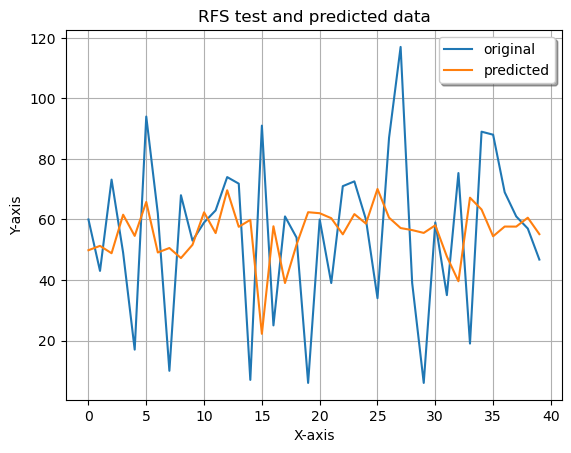

Lreg MAE score: 22.145754128973046
Lreg best param: {'fit_intercept': True}
Lreg best estimator: LinearRegression()



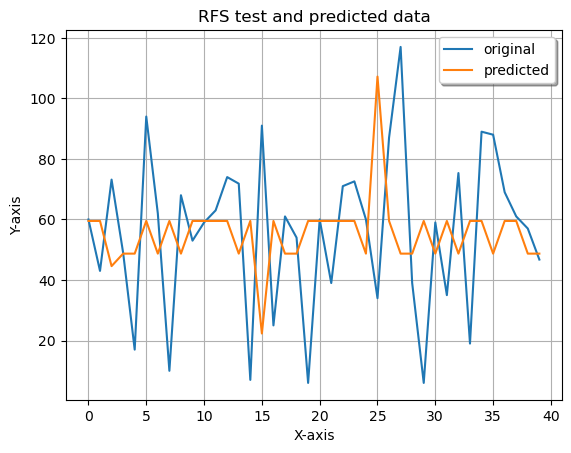

DTreg MAE score: 23.7509375
DTreg best param: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 3}
DTreg best estimator: DecisionTreeRegressor(max_depth=3, max_features='log2', min_samples_leaf=3)



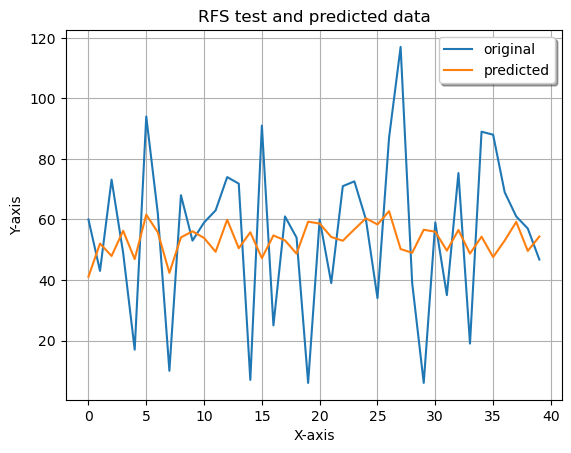

SVMreg MAE score: 20.55868050951227
SVMreg best param: {'C': 6, 'gamma': 'auto', 'kernel': 'rbf'}
SVMreg best estimator: SVR(C=6, gamma='auto')



In [24]:
""" 25 features 20:80 split, X_train used on GridsearchCV, then X_test used for evaluation (no cross validation)"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

def plot_draw(y_test, y_pred):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

##############################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

Lmodel = GridSearchCV(Lreg, param_grid=lreg_parameters, cv=outer_cv, n_jobs=2)
Lmodel.fit(X_train, y_train)
best_estimator = Lmodel.best_estimator_
y_pred = best_estimator.predict(X_test)
score = metrics.mean_absolute_error(y_pred, y_test)
plot_draw(y_test, y_pred)

print("Lreg MAE score: {}".format(score))
print("Lreg best param: {}".format(Lmodel.best_params_))
print("Lreg best estimator: {}\n".format(best_estimator))

##############################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

DTmodel = GridSearchCV(DTreg, param_grid=dt_parameters, cv=outer_cv, n_jobs=2)
DTmodel.fit(X_train, y_train)
best_estimator = DTmodel.best_estimator_
y_pred = best_estimator.predict(X_test)
score = metrics.mean_absolute_error(y_pred, y_test)
plot_draw(y_test, y_pred)

print("DTreg MAE score: {}".format(score))
print("DTreg best param: {}".format(DTmodel.best_params_))
print("DTreg best estimator: {}\n".format(best_estimator))

#################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

SVMmodel = GridSearchCV(SVMreg, param_grid=svm_parameters, cv=outer_cv, n_jobs=2)
SVMmodel.fit(X_train, y_train)
best_estimator = SVMmodel.best_estimator_
y_pred = best_estimator.predict(X_test)
score = metrics.mean_absolute_error(y_pred, y_test)
plot_draw(y_test, y_pred)

print("SVMreg MAE score: {}".format(score))
print("SVMreg best param: {}".format(SVMmodel.best_params_))
print("SVMreg best estimator: {}\n".format(best_estimator))


/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/Users/yidan/opt/anaconda3/envs/mle_tf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=1000. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'units3': 5, 'units2': 5, 'units1': 5, 'activation3': 'exponential', 'activation2': 'exponential', 'activation1': 'sigmoid'}


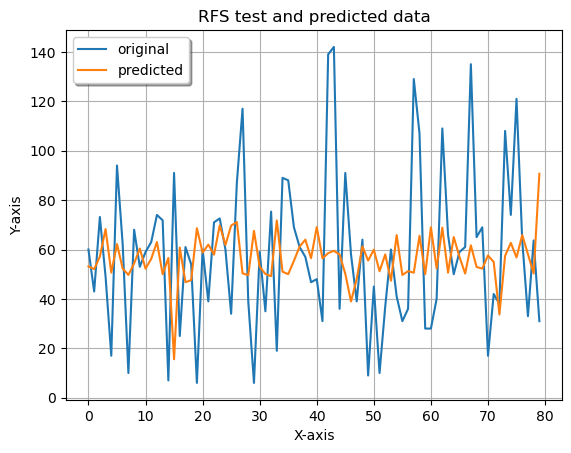

25.991524322827654


In [ ]:
# ### ANN model
# # k-fold cross validation
# ann_parameters = {"units1":[2,3,4,5,6,7],
# "units2":[2,3,4,5,6,7],
# "units3":[2,3,4,5,6,7],
# "activation1": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation2": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation3": ['relu','tanh', 'sigmoid', 'exponential']}

# ann_parameters = {"units1":[2,5,8,11,14,17,20],
# "units2":[2,5,8,11,14,17,20],
# "units3":[2,5,8,11,14,17,20],
# "activation1": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation2": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation3": ['relu','tanh', 'sigmoid', 'exponential']}

# parameters = {"units1":[5],
# "units2":[5],
# "units3":[5],
# "activation1": ['sigmoid'],
# "activation2": ['exponential'],
# "activation3": ['exponential']}

# ## call model
# def create_model(units1, units2, units3, activation1, activation2, activation3):

#     # create model
#     # create ANN model
#     ANNreg = Sequential()
    
#     # Defining the Input layer and FIRST hidden layer, both are same!
#     ANNreg.add(Dense(units1, input_dim=25,kernel_initializer='normal', activation = activation1))
    
#     #Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units2, kernel_initializer='normal', activation=activation2))
    
#     # Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units3, kernel_initializer='normal', activation=activation3))

#     # # Defining the Second layer of the model
#     # # after the first layer we don't have to specify input_dim as keras configure it automatically
#     # ANNreg.add(Dense(units, kernel_initializer='normal', activation='tanh'))
    
#     # The output neuron is a single fully connected node 
#     # Since we will be predicting a single number
#     ANNreg.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
#     return ANNreg

# annReg = KerasRegressor(build_fn = create_model, epochs = 100, batch_size = 10, verbose = 0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# #model = GridSearchCV(annReg, param_grid=ann_parameters, cv=5, n_jobs=2)
# model = RandomizedSearchCV(annReg, parameters, cv=5, n_jobs=2, n_iter=1000)
# model.fit(X_train, y_train)
# best_estimator = model.best_estimator_
# print(model.best_params_)

# y_pred = best_estimator.predict(X_test)
# score = metrics.mean_absolute_error(y_pred, y_test)

# x_ax = range(len(y_test))
# plt.plot(x_ax, y_test, label="original")
# plt.plot(x_ax, y_pred, label="predicted")
# plt.title("RFS test and predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()

# print(score)
# print(best_estimator)

## 1.3 Nested Cross Validation

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ..............fit_intercept=True;, score=-0.035 total time=   0.0s
[CV 2/10] END ...............fit_intercept=True;, score=0.074 total time=   0.0s
[CV 3/10] END ..............fit_intercept=True;, score=-0.073 total time=   0.0s
[CV 4/10] END ..............fit_intercept=True;, score=-0.108 total time=   0.0s
[CV 5/10] END ...............fit_intercept=True;, score=0.028 total time=   0.0s
[CV 6/10] END ..............fit_intercept=True;, score=-0.324 total time=   0.0s
[CV 7/10] END ...............fit_intercept=True;, score=0.132 total time=   0.0s
[CV 8/10] END ..............fit_intercept=True;, score=-0.251 total time=   0.0s
[CV 9/10] END ...............fit_intercept=True;, score=0.141 total time=   0.0s
[CV 1/10] END .............fit_intercept=False;, score=-0.414 total time=   0.0s
[CV 10/10] END ..............fit_intercept=True;, score=0.030 total time=   0.0s
[CV 2/10] END .............fit_intercept=False;,

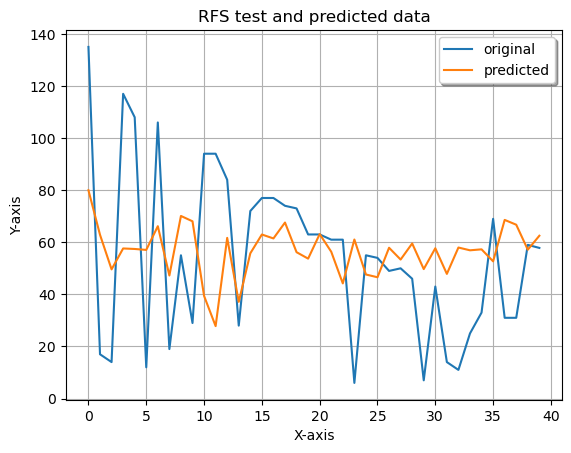

Lreg MAE score: 21.19503435117317
Lreg best param: {'fit_intercept': True}
Lreg best estimator: LinearRegression()

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.135 total time=   0.0s
[CV 2/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.096 total time=   0.0s
[CV 3/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.082 total time=   0.0s
[CV 4/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.063 total time=   0.0s
[CV 5/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.228 total time=   0.0s
[CV 6/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.337 total time=   0.0s
[CV 7/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=0.083 total time=   0.0s
[CV 8/10] END max_depth=3, max_features=auto, min_samples_leaf=3;, score=-0.260 total time=   0.0s
[CV 9/10] END max_depth=3, max

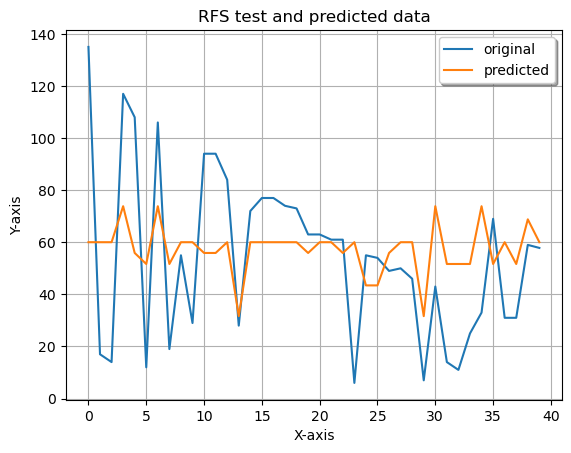

DTreg MAE score: 21.59157432445412
DTreg best param: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 9}
DTreg best estimator: DecisionTreeRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=9)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END ......C=1, gamma=0.1, kernel=rbf;, score=-0.086 total time=   0.0s
[CV 2/10] END .......C=1, gamma=0.1, kernel=rbf;, score=0.031 total time=   0.0s
[CV 3/10] END ......C=1, gamma=0.1, kernel=rbf;, score=-0.057 total time=   0.0s
[CV 4/10] END ......C=1, gamma=0.1, kernel=rbf;, score=-0.042 total time=   0.0s
[CV 5/10] END .......C=1, gamma=0.1, kernel=rbf;, score=0.014 total time=   0.0s
[CV 7/10] END .......C=1, gamma=0.1, kernel=rbf;, score=0.020 total time=   0.0s
[CV 6/10] END ......C=1, gamma=0.1, kernel=rbf;, score=-0.013 total time=   0.0s
[CV 8/10] END ......C=1, gamma=0.1, kernel=rbf;, score=-0.043 total time=   0.0s
[CV 9/10] END .......C=1, gamma=0.1, kernel=rbf;, score=0.022 total time=

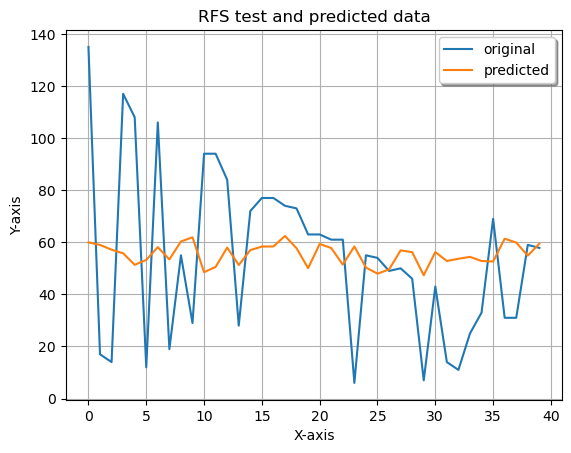

SVMreg MAE score: 20.63244379441574
SVMreg best param: {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}
SVMreg best estimator: SVR(C=2, gamma='auto')



In [25]:
""" 25 features nested cross validation """

def cross_val(estimator, X, y, parameters, inner_cv, outer_cv):
    scores = []
    best_estimator = []
    best_params = {}
    best_score = -100
    for train, test in outer_cv.split(X):
        # training and validation
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]

        model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2, verbose=3)
        #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=1000)
        model.fit(X_train, y_train)
        # model.save(os.path.join('{}_nested_fold_{}_model.hdf5'.format(str, i)))
            # if model.best_params_ != best_params: 
            #     #print(model.best_estimator_ == best_estimator)
            #     best_estimator.append(model.best_estimator_)
            #     best_params = model.best_params_
        # evaluate the accuracy of each fold
        prediction = model.best_estimator_.predict(X_test)
        score = metrics.mean_absolute_error(y_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)
        scores.append(score)

        if best_score <= score:
            best_score = score
            y_best = y_test
            y_pred = prediction
            best_estimator = model.best_estimator_
            best_params = model.best_params_
        
    x_ax = range(len(y_best))
    plt.plot(x_ax, y_best, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 
    return np.array(scores), best_estimator, best_params

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

test_score, estimator, param = cross_val(Lreg, X, y, lreg_parameters, inner_cv, outer_cv)
print("Lreg MAE score: {}".format(np.array(test_score).mean()))
print("Lreg best param: {}".format(param))
print("Lreg best estimator: {}\n".format(estimator))

################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

test_score, estimator, param = cross_val(DTreg, X, y, dt_parameters, inner_cv, outer_cv)
print("DTreg MAE score: {}".format(np.array(test_score).mean()))
print("DTreg best param: {}".format(param))
print("DTreg best estimator: {}\n".format(estimator))

################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto'],
           "C": [1,2,3,4,5,6]}

## call model
SVMreg = svm.SVR()

test_score, estimator, param = cross_val(SVMreg, X, y, svm_parameters, inner_cv, outer_cv)
print("SVMreg MAE score: {}".format(np.array(test_score).mean()))
print("SVMreg best param: {}".format(param))
print("SVMreg best estimator: {}\n".format(estimator))



In [ ]:
# ### Ann
# ann_parameters = {"units1":[2,5,8,11,14,17,20],
# "units2":[2,5,8,11,14,17,20],
# "units3":[2,5,8,11,14,17,20],
# "activation1": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation2": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation3": ['relu','tanh', 'sigmoid', 'exponential']}

# ## call model
# def create_model(units1, units2, units3, activation1, activation2, activation3):

#     # create model
#     # create ANN model
#     ANNreg = Sequential()
    
#     # Defining the Input layer and FIRST hidden layer, both are same!
#     ANNreg.add(Dense(units1, input_dim=25,kernel_initializer='normal', activation = activation1))
    
#     #Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units2, kernel_initializer='normal', activation=activation2))
    
#     # Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units3, kernel_initializer='normal', activation=activation3))

#     # # Defining the Second layer of the model
#     # # after the first layer we don't have to specify input_dim as keras configure it automatically
#     # ANNreg.add(Dense(units, kernel_initializer='normal', activation='tanh'))
    
#     # The output neuron is a single fully connected node 
#     # Since we will be predicting a single number
#     ANNreg.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
#     return ANNreg

# Annreg = KerasRegressor(build_fn = create_model, epochs = 100, batch_size = 10, verbose = 0)

# test_score, estimator, param = cross_val(Annreg, X, y, ann_parameters, inner_cv, outer_cv)
# print("Annreg MAE score: {}".format(np.array(test_score).mean()))
# print("Annreg best param: {}".format(param))
# print("Annreg best estimator: {}\n".format(estimator))

## 1.4 1/9 split and 90% on Gridsearch then use Cross validaiton evaluation (cv=10) on the whole dataset

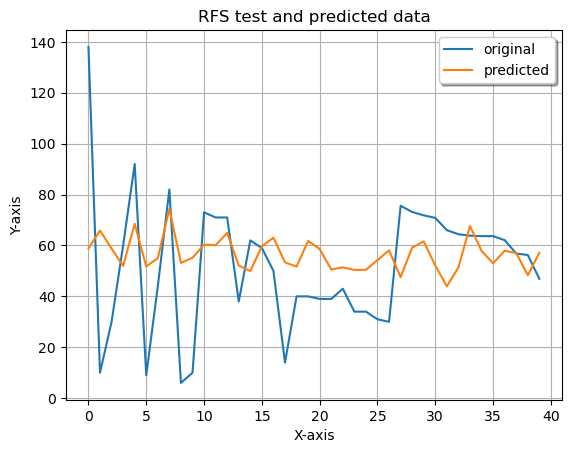

Lreg MAE score: 21.19503435117317
Lreg best param: {'fit_intercept': True}
Lreg best estimator: LinearRegression()



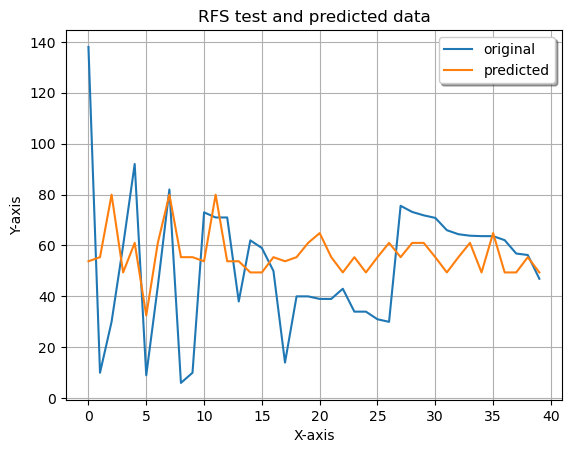

DTreg MAE score: 21.40460095704062
DTreg best param: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 3}
DTreg best estimator: DecisionTreeRegressor(max_depth=3, max_features='log2', min_samples_leaf=3)



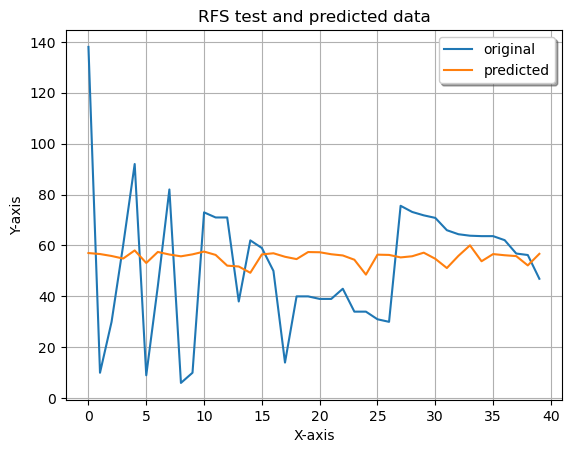

SVMreg MAE score: 20.70885091550369
SVMreg best param: {'gamma': 'auto', 'kernel': 'sigmoid'}
SVMreg best estimator: SVR(gamma='auto', kernel='sigmoid')



In [26]:
def cross_val_2(estimator, X, y, parameters, inner_cv, outer_cv):
    scores = []
    best_estimator = estimator
    best_params = parameters

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    model = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, n_jobs=2)
    #model = RandomizedSearchCV(estimator, parameters, cv=inner_cv, n_jobs=4, n_iter=1000)
    model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    best_param = model.best_params_

    for train, test in outer_cv.split(X):
        # training and validation
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]

        best_estimator.fit(X_train, y_train)
        # evaluate the accuracy of each fold
        prediction = best_estimator.predict(X_test)
        score = metrics.mean_absolute_error(y_test, prediction) # use mse as metrics in K-fold, np.array(y_test), verbose=0)
        scores.append(score)
    
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, prediction, label="predicted")
    plt.title("RFS test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()   
    return np.array(scores), best_estimator, best_param

inner_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)
outer_cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=8)

#################################################################################

#hyper parameter tuning for LinearRegression
lreg_parameters = {"fit_intercept":[True,False]}

## call model
Lreg = linear_model.LinearRegression()

test_score, estimator, param = cross_val_2(Lreg, X, y, lreg_parameters, inner_cv, outer_cv)
print("Lreg MAE score: {}".format(np.array(test_score).mean()))
print("Lreg best param: {}".format(param))
print("Lreg best estimator: {}\n".format(estimator))

#################################################################################

#hyper parameter tuning for Decision Tree
dt_parameters = {"max_depth" : [3,9,12],
           "min_samples_leaf":[3,6,9],
           "max_features":["auto","log2","sqrt",None]}

## call model
DTreg = DecisionTreeRegressor()

test_score, estimator, param = cross_val_2(DTreg, X, y, dt_parameters, inner_cv, outer_cv)
print("DTreg MAE score: {}".format(np.array(test_score).mean()))
print("DTreg best param: {}".format(param))
print("DTreg best estimator: {}\n".format(estimator))

#################################################################################

#hyper parameter tuning for SVM
svm_parameters = {"kernel":['rbf', 'sigmoid'],
           "gamma":[0.1,1.0,10.0,'scale','auto']}

## call model
SVMreg = svm.SVR()

test_score, estimator, param = cross_val_2(SVMreg, X, y, svm_parameters, inner_cv, outer_cv)
print("SVMreg MAE score: {}".format(np.array(test_score).mean()))
print("SVMreg best param: {}".format(param))
print("SVMreg best estimator: {}\n".format(estimator))

In [ ]:
# ### Ann
# ann_parameters = {"units1":[2,5,8,11,14,17,20],
# "units2":[2,5,8,11,14,17,20],
# "units3":[2,5,8,11,14,17,20],
# "activation1": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation2": ['relu','tanh', 'sigmoid', 'exponential'],
# "activation3": ['relu','tanh', 'sigmoid', 'exponential']}

# ## call model
# def create_model(units1, units2, units3, activation1, activation2, activation3):

#     # create model
#     # create ANN model
#     ANNreg = Sequential()
    
#     # Defining the Input layer and FIRST hidden layer, both are same!
#     ANNreg.add(Dense(units1, input_dim=25,kernel_initializer='normal', activation = activation1))
    
#     #Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units2, kernel_initializer='normal', activation=activation2))
    
#     # Defining the Second layer of the model
#     # after the first layer we don't have to specify input_dim as keras configure it automatically
#     ANNreg.add(Dense(units3, kernel_initializer='normal', activation=activation3))

#     # # Defining the Second layer of the model
#     # # after the first layer we don't have to specify input_dim as keras configure it automatically
#     # ANNreg.add(Dense(units, kernel_initializer='normal', activation='tanh'))
    
#     # The output neuron is a single fully connected node 
#     # Since we will be predicting a single number
#     ANNreg.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     ANNreg.compile(optimizer = 'adam', loss ='mean_absolute_error')
#     return ANNreg

# Annreg = KerasRegressor(build_fn = create_model, epochs = 100, batch_size = 10, verbose = 0)

# test_score, estimator, param = cross_val_2(Annreg, X, y, ann_parameters, inner_cv, outer_cv)
# print("Annreg MAE score: {}".format(np.array(test_score).mean()))
# print("Annreg best param: {}".format(param))
# print("Annreg best estimator: {}\n".format(estimator))